In [3]:
import numpy as np
import struct
from math import sqrt, log10
import sys

"""
Functions
"""
###############################################################################

"""
Load a QUANT format matrix into python.
A QUANT matrix stores the row count (m), column count (n) and then m x n IEEE754 floats (4 byte) of data
"""
def loadQUANTMatrix(filename):
    with open(filename,'rb') as f:
        (m,) = struct.unpack('i', f.read(4))
        (n,) = struct.unpack('i', f.read(4))
        print("loadQUANTMatrix::m=",m,"n=",n)
        matrix = np.arange(m*n,dtype=np.float64).reshape(m, n) #and hopefully m===n, but I'm not relying on it
        for i in range(0,m):
            data = struct.unpack('{0}f'.format(n), f.read(4*n)) #read a row back from the stream - data=list of floats
            for j in range(0,n):
                matrix[i,j] = data[j]
    return matrix

###############################################################################

def SorensonDice(X, Y):
    #(m,n) = X.shape
    Phi = 0.0
    C0 = 0.0
    C1 = 0.0
    #for i in range(0, m):
    #    for j in range(0, n):
    #        C0 += min(X[i, j], Y[i, j])
    #        C1 += X[i, j] + Y[i, j]
    #Phi = 2.0 * C0 / C1;
    Mmin = np.minimum(X,Y)
    C0=np.sum(Mmin)
    C1=np.sum(X)+np.sum(Y)
    Phi = 2.0 * C0 / C1;
    return Phi

###############################################################################

def RMS(X, Y):
    #(m,n) = X.shape
    S = 0.0
    #C0 = 0.0
    #n2 = m * n #number of elements in sample i.e. matrix elements
    #for i in range(0, m):
    #    for j in range(0,n):
    #        C0 += pow(X[i, j] - Y[i, j], 2)
    #S = sqrt(C0/n2)
    S = np.sqrt(np.mean(np.power(X-Y,2)))

    return S

###############################################################################

"""
Test of RMS on list - produces same results as RMS, so it works
"""
def RMStest(X,Y):
    n = len(X)
    S = 0.0
    C0 = 0.0
    for i in range(0, n):
        C0 += pow(X[i] - Y[i], 2)/n
    S = sqrt(C0)

    return S

###############################################################################

def Normalise(M):
    #m, n = M.shape
    #Norm = np.arange(m*n).reshape(m, n)
    #Sumtest = 0.0
    #for i in range(0,m):
    #    for j in range(0,n):
    #        Sumtest += M[i, j]
    #for i in range(0,m):
    #    for j in range(0,n):
    #        Norm[i,j] = M[i, j]/Sumtest
    #        #TRAP! Any underflow values that end up as zero get set to epsilon 1e-45
    #        if Norm[i, j] == 0:
    #            Norm[i, j] = sys.float_info.epsilon
    #        ##
    Sum=np.sum(M,dtype=np.float64)
    #print("SUM: "+str(Sum))
    Norm=np.divide(M,Sum)
    Norm[Norm<=0.0]=sys.float_info.epsilon
    return Norm

###############################################################################

def Entropy(pij_obs, pij_pred):
    #m,n = pij_obs.shape
    H = 0.0
    #for i in range(0,m):
    #    for j in range(0,n):
    #        #if (pij_pred[i,j]==0):
    #        #    pij_pred[i,j]=sys.float_info.epsilon
    #        if (pij_obs[i,j]>0) and (pij_pred[i,j]>0):
    #            H += pij_obs[i, j] * np.log10(pij_obs[i, j] / pij_pred[i, j])
    H = np.sum(pij_obs*np.log10(pij_obs/pij_pred))
    return H

###############################################################################

def Correlation(X, Y):
    #(m,n) = X.shape
    MeanX = np.mean(X)
    MeanY = np.mean(Y)
    r = 0.0
    #C0 = 0.0
    #C1 = 0.0
    #C2 = 0.0
    #C3 = 0.0
    #C4 = 0.0
    #for i in range(0,m):
    #    for j in range(0,n):
    #        C0 = X[i, j] - MeanX
    #        C1 = Y[i, j] - MeanY
    #        C4 += C0 * C1
    #        C2 += np.power(X[i, j] - MeanX, 2)
    #        C3 += np.power(Y[i, j] - MeanY, 2)
    #r = C4 / (sqrt(C2) * sqrt(C3))
    C0=X-MeanX
    C1=Y-MeanY
    C4 = np.sum(C0*C1)
    C2 = np.sum(np.power(C0,2))
    C3 = np.sum(np.power(C1,2))
    r= C4 / (np.sqrt(C2) * np.sqrt(C3))
    return r

###############################################################################

def fake_log(tij):
    return np.where(tij>=1.0,np.log(tij)+1.0,tij)

###############################################################################

Sorenson-Dice
$$
\phi = 2 \frac{\sum_{ij} min[ X_{ij}, Y_{ij} ]} { \sum_{ij} X_{ij} + \sum_{ij} Y_{ij} }
$$

Sorenson-Dice by mode
$$
\phi^m = 2 \frac{\sum_{ij} min[ T_{ij}^m(model), T_{ij}^m(obs) ]} { \sum_{ij} T_{ij}^m(model) + \sum_{ij} T_{ij}^m(obs) }, 0 \le \phi^m \le 1
$$

Soreneson-Dice total all modes
$$
\phi = 2 \frac{\sum_{ij} min[ T_{ij}(model), T_{ij}(obs) ]} { \sum_{ij} T_{ij}(model) + \sum_{ij} T_{ij}(obs) }, 0 \le \phi \le 1
$$

Sorenson-Dice population
$$
\vartheta = 2 \frac{\sum_{i} min[ P_{j}(model), P_{j}(obs) ]} { \sum_{ij} P_{j}(model) + \sum_{ij} P_{j}(obs) }, 0 \le \vartheta \le 1
$$

RMS (Root Mean Square)
$$
S = \sqrt{ \sum_{ij} ( [ X_{ij} - Y_{ij} ]^2 / n^2 ) }
$$

RMS (Root Mean Square) by mode
$$
S^m = \sqrt{ \sum_{ij} ( [ T_{ij}^m(model) - T_{ij}^m(obs) ]^2 / n^2 ) }
$$

RMS (Root Mean Square) total all modes
$$
S = \sqrt{ \sum_{ij} ( [ T_{ij}(model) - T_{ij}(obs) ]^2 / n^2 ) }
$$

RMS (Root Mean Square) population
$$
R = \sqrt{ \sum_{i} ( [ P_{j}(model) - P_{j}(obs) ]^2 / n ) }
$$

Entropy
$$
H = \sum_{ij} [ X_{ij} \log \frac{X_{ij}} {Y_{ij}} ]
$$

Entropy by mode
$$
H^m = \sum_{ij} [ p_{ij}^m(obs) \log \frac{p_{ij}^m(obs)} {p_{ij}^m(model)} ], \sum_{ij}p_{ij}^m = 1
$$

Entropy total all modes
$$
H = \sum_{ij} [ p_{ij}(obs) \log \frac{p_{ij}(obs)} {p_{ij}(model)} ], \sum_{ij}p_{ij} = 1
$$

Entropy population
$$
H^P = \sum_{i} [ p_{j}(obs) \log \frac{p_{j}(obs)} {p_{j}(model)} ], \sum_{j}p_{j} = 1
$$

Correlation
$$
r = \frac{ \sum_{ij} (X_{ij}-\bar{X})(Y_{ij}-\bar{Y}) } { \sqrt{ \sum_{ij} (X_{ij}-\bar{X})^2 } \sqrt{ \sum_{ij} (Y_{ij}-\bar{Y})^2 }  }
$$

Correlation by mode
$$
r^m =  \frac{ \sum_{ij} [T_{ij}^m(obs)-\overline{T_{ij}^m(obs)}] [T_{ij}^m(model)-\overline{T_{ij}^m(model)}] } { \sqrt{ \sum_{ij} [T_{ij}^m(obs)-\overline{T_{ij}^m(obs)}]^2} \sqrt{ \sum_{ij} [T_{ij}^m(model)-\overline{T_{ij}^m(model)}]^2 }  }
$$

Correlation total all modes
$$
r =  \frac{ \sum_{ij} [T_{ij}(obs)-\overline{T_{ij}(obs)}] [T_{ij}(model)-\overline{T_{ij}(model)}] } { \sqrt{ \sum_{ij} [T_{ij}(obs)-\overline{T_{ij}(obs)}]^2} \sqrt{ \sum_{ij} [T_{ij}(model)-\overline{T_{ij}(model)}]^2 }  }
$$

In [18]:
import os.path
import urllib.request
import shutil
import ssl

"""
Data Locations on OSF.IO
"""
url_QUANT2_Tij_Obs_road = 'https://osf.io/ga9m3/download'
url_QUANT2_Tij_Obs_bus = 'https://osf.io/nfepz/download'
url_QUANT2_Tij_Obs_rail = 'https://osf.io/at9vc/download'
url_QUANT2_Tij_Pred_road = 'https://osf.io/an2yv/download'
url_QUANT2_Tij_Pred_bus = 'https://osf.io/vjd7x/download'
url_QUANT2_Tij_Pred_rail = 'https://osf.io/4j68z/download'

"""
Load data
todo: pull from OSF directly? same as umaas does on dafni?
"""
#modelrunsdir = "../../QUANT2/quant2/wwwroot/model-runs"
#modelrunsdir="C:/Users/richard/Desktop/QUANT2LIVE"
modelrunsdir = "model-runs"
prefixmodelrunsdir = modelrunsdir+"/EWS"
os.mkdirs(prefixmodelrunsdir)

#obs
Tij_Obs_filename = "TObs.bin"
Tij_Obs_road_filename = "TObs_1.bin"
Tij_Obs_bus_filename = "TObs_2.bin"
Tij_Obs_rail_filename = "TObs_3.bin"
#pred
Tij_Pred_filename = "TPred.bin"
Tij_Pred_road_filename = "TPred_Q3_1.bin"
Tij_Pred_bus_filename = "TPred_Q3_2.bin"
Tij_Pred_rail_filename = "TPred_Q3_3.bin"

#check for existence of matrices and download if required from OSF.IO
filelist = [
    Tij_Obs_road_filename, Tij_Pred_road_filename,
    Tij_Obs_bus_filename, Tij_Pred_bus_filename,
    Tij_Obs_rail_filename, Tij_Pred_rail_filename ]
urllist = [
    url_QUANT2_Tij_Obs_road, url_QUANT2_Tij_Pred_road,
    url_QUANT2_Tij_Obs_bus, url_QUANT2_Tij_Pred_bus,
    url_QUANT2_Tij_Obs_rail, url_QUANT2_Tij_Pred_rail ]

ssl._create_default_https_context = ssl._create_unverified_context
for idx, filename in enumerate(filelist):
    fullname = os.path.join(prefixmodelrunsdir,filename)
    if not os.path.isfile(fullname):
        print("downloading "+filename+" from "+urllist[idx])
        #linux !wget -O fullname urllist[idx]
        try:
            with urllib.request.urlopen(urllist[idx]) as response:
                with open(fullname,'wb') as f:
                    shutil.copyfileobj(response,f)
        except FileNotFoundError:
            print("File not found: ",fullname)
#end for

#load matrices
#Tij_Obs = loadQUANTMatrix(os.path.join(prefixmodelrunsdir,Tij_Obs_filename)) #REMOVED - see below
#Tij_Pred = loadQUANTMatrix(os.path.join(prefixmodelrunsdir,Tij_Pred_filename))
Tij_Obs_road = loadQUANTMatrix(os.path.join(prefixmodelrunsdir,Tij_Obs_road_filename))
Tij_Pred_road = loadQUANTMatrix(os.path.join(prefixmodelrunsdir,Tij_Pred_road_filename))
Tij_Obs_bus = loadQUANTMatrix(os.path.join(prefixmodelrunsdir,Tij_Obs_bus_filename))
Tij_Pred_bus = loadQUANTMatrix(os.path.join(prefixmodelrunsdir,Tij_Pred_bus_filename))
Tij_Obs_rail = loadQUANTMatrix(os.path.join(prefixmodelrunsdir,Tij_Obs_rail_filename))
Tij_Pred_rail = loadQUANTMatrix(os.path.join(prefixmodelrunsdir,Tij_Pred_rail_filename))
#we have to add the all modes matrices because they don't exist in this form on the server
Tij_Obs = Tij_Obs_road + Tij_Obs_bus + Tij_Obs_rail
Tij_Pred = Tij_Pred_road + Tij_Pred_bus + Tij_Pred_rail
#print (Tij_Obs.shape)
#sanity check that they add up (more or less)
print("sum(Tij_Obs)="+str(np.sum(Tij_Obs))+" sum(Tij_Pred)="+str(np.sum(Tij_Pred)))


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'model-runs/EWS'

In [12]:
"""
Log Statistics
"""
log_Tij_Obs = fake_log(Tij_Obs) #np.log(np.where(Tij_Obs<=0,sys.float_info.epsilon,Tij_Obs),dtype=np.float64)
log_Tij_Pred = fake_log(Tij_Pred) #np.log(np.where(Tij_Pred<=0,sys.float_info.epsilon,Tij_Pred),dtype=np.float64)
log_Tij_Obs_road = fake_log(Tij_Obs_road) #np.log(np.where(Tij_Obs_road<=0,sys.float_info.epsilon,Tij_Obs_road),dtype=np.float64)
log_Tij_Pred_road = fake_log(Tij_Pred_road) #np.log(np.where(Tij_Pred_road<=0,sys.float_info.epsilon,Tij_Pred_road),dtype=np.float64)
log_Tij_Obs_bus = fake_log(Tij_Obs_bus) #np.log(np.where(Tij_Obs_bus<=0,sys.float_info.epsilon,Tij_Obs_bus),dtype=np.float64)
log_Tij_Pred_bus = fake_log(Tij_Pred_bus) #np.log(np.where(Tij_Pred_bus<=0,sys.float_info.epsilon,Tij_Pred_bus),dtype=np.float64)
log_Tij_Obs_rail = fake_log(Tij_Obs_rail) #np.log(np.where(Tij_Obs_rail<=0,sys.float_info.epsilon,Tij_Obs_rail),dtype=np.float64)
log_Tij_Pred_rail = fake_log(Tij_Pred_rail) #np.log(np.where(Tij_Pred_rail<=0,sys.float_info.epsilon,Tij_Pred_rail),dtype=np.float64)
sum_obs = np.sum(log_Tij_Obs)
sum_pred = np.sum(log_Tij_Pred)
print("sum log Tij obs="+str(sum_obs)+" pred="+str(sum_pred))

C:\Users\richard\AppData\Local\Temp\ipykernel_7796\2169773759.py:142: RuntimeWarning: divide by zero encountered in log
  return np.where(tij>=1.0,np.log(tij)+1.0,tij)


sum log Tij obs=4858253.628415111 pred=8027713.5989568215


In [13]:
"""
Sorenson Dice statistics
"""
import csv

Phi = SorensonDice(Tij_Obs,Tij_Pred)
Phi_road = SorensonDice(Tij_Obs_road,Tij_Pred_road)
Phi_bus = SorensonDice(Tij_Obs_bus,Tij_Pred_bus)
Phi_rail = SorensonDice(Tij_Obs_rail,Tij_Pred_rail)
print("SorensonDice: Phi_road="+str(Phi_road)+" Phi_bus="+str(Phi_bus)+" Phi_rail="+str(Phi_rail))
print("SorensonDice: All Modes Phi="+str(Phi))
#now population Pj
Pj_Obs = Tij_Obs.sum(axis=0)
Pj_Pred = Tij_Pred.sum(axis=0)
### hack - write out Pj obs and pred to file
with open('Pj_Obs_Pred.csv','w',encoding='UTF8', newline='') as f:
    writer = csv.writer(f)
    #write header row
    writer.writerow(['zonei','Pj_Obs','Pj_Pred'])
    for i in range(0,len(Pj_Obs)):
        data = [ i, Pj_Obs[i], Pj_Pred[i] ]
        writer.writerow(data)
###

v = SorensonDice(Pj_Pred, Pj_Obs)
print("SorensonDice v="+str(v))

#now log statistics
logPhi = SorensonDice(log_Tij_Obs,log_Tij_Pred)
logPhi_road = SorensonDice(log_Tij_Obs_road,log_Tij_Pred_road)
logPhi_bus = SorensonDice(log_Tij_Obs_bus,log_Tij_Pred_bus)
logPhi_rail = SorensonDice(log_Tij_Obs_rail,log_Tij_Pred_rail)
print("LOG SorensonDice: Log_Phi_road="+str(logPhi_road)+" Log_Phi_bus="+str(logPhi_bus)+" Log_Phi_rail="+str(logPhi_rail))
print("LOG SorensonDice: All Modes Log_Phi="+str(logPhi))

SorensonDice: Phi_road=0.43569086451846434 Phi_bus=0.41721070318431047 Phi_rail=0.2143529742714542
SorensonDice: All Modes Phi=0.6063760664553149
SorensonDice v=0.8664244569512263
LOG SorensonDice: Log_Phi_road=0.5672238392649798 Log_Phi_bus=0.4332304547871472 Log_Phi_rail=0.20047755523902483
LOG SorensonDice: All Modes Log_Phi=0.5602541308792627


In [15]:
"""
RMS statistics
"""
S = RMS(Tij_Pred, Tij_Obs)
S_road = RMS(Tij_Pred_road, Tij_Obs_road)
S_bus = RMS(Tij_Pred_bus, Tij_Obs_bus)
S_rail = RMS(Tij_Pred_rail, Tij_Obs_rail)
print("RMS: road=" + str(S_road) + " bus=" + str(S_bus) + " rail=" + str(S_rail))
print("RMS All Modes=" + str(S))

R = RMS(Pj_Pred, Pj_Obs)
print("RMS: R=" + str(R))
#Rtest = RMStest(Pj_Pred, Pj_Obs)
#print("RMStest: R=" + str(Rtest))

#now log statistics
logS = RMS(log_Tij_Pred, log_Tij_Obs)
logS_road = RMS(log_Tij_Pred_road, log_Tij_Obs_road)
logS_bus = RMS(log_Tij_Pred_bus, log_Tij_Obs_bus)
logS_rail = RMS(log_Tij_Pred_rail, log_Tij_Obs_rail)
print("LOG RMS: Log_road=" + str(logS_road) + " Log_bus=" + str(logS_bus) + " Log_rail=" + str(logS_rail))
print("LOG RMS All Modes=" + str(logS))

logR = RMS(np.log(Pj_Pred), np.log(Pj_Obs))
print("LOG RMS: Log_R=" + str(logR))
#Rtest = RMStest(Pj_Pred, Pj_Obs)
#print("RMStest: R=" + str(Rtest))


RMS: road=3.6668180671997015 bus=0.8969870725270076 rail=1.572054279119074
RMS All Modes=3.064587981131736
RMS: R=844.2240348197972
LOG RMS: Log_road=0.2309582297177451 Log_bus=0.15189403622259642 Log_rail=0.30670260348949563
LOG RMS All Modes=0.2923670636761044
LOG RMS: Log_R=0.378680427952645


In [16]:
"""
Entropy statistics
"""
pij_Obs_road = Normalise(Tij_Obs_road)
pij_Obs_bus = Normalise(Tij_Obs_bus)
pij_Obs_rail = Normalise(Tij_Obs_rail)
pij_Pred_road = Normalise(Tij_Pred_road)
pij_Pred_bus = Normalise(Tij_Pred_bus)
pij_Pred_rail = Normalise(Tij_Pred_rail)

H_road = Entropy(pij_Obs_road, pij_Pred_road)
H_bus = Entropy(pij_Obs_bus, pij_Pred_bus)
H_rail = Entropy(pij_Obs_rail, pij_Pred_rail)
print("Entropy: Hroad=" + str(H_road) + " Hbus=" + str(H_bus) + " Hrail=" + str(H_rail))

pij_Obs = Normalise(Tij_Obs)
pij_Pred = Normalise(Tij_Pred)
H = Entropy(pij_Obs, pij_Pred)
print("Entropy: H=" + str(H))

pj_Obs = Normalise(Pj_Obs)
pj_Pred = Normalise(Pj_Pred)
Hp = Entropy(pj_Obs, pj_Pred)
print("Entropy: Hp=" + str(Hp))

Entropy: Hroad=0.41854499210729096 Hbus=0.6497290683893168 Hrail=0.941934690399652
Entropy: H=0.2944448641378275
Entropy: Hp=0.026096126952883034


In [17]:
"""
Correlations
"""
r_road = Correlation(Tij_Obs_road,Tij_Pred_road)
r_bus = Correlation(Tij_Obs_bus,Tij_Pred_bus)
r_rail = Correlation(Tij_Obs_rail,Tij_Pred_rail)
print("Correlation: r_road="+str(r_road)+" r_bus="+str(r_bus)+" r_rail="+str(r_rail))
r=Correlation(Tij_Obs,Tij_Pred)
print("Correlation: r all modes="+str(r))

#LOG CORRELATIONS
logr_road = Correlation(log_Tij_Obs_road,log_Tij_Pred_road)
logr_bus = Correlation(log_Tij_Obs_bus,log_Tij_Pred_bus)
logr_rail = Correlation(log_Tij_Obs_rail,log_Tij_Pred_rail)
print("LOG Correlation: Log_r_road="+str(logr_road)+" Log_r_bus="+str(logr_bus)+" Log_r_rail="+str(logr_rail))
logr=Correlation(log_Tij_Obs,log_Tij_Pred)
print("LOG Correlation: Log_r all modes="+str(logr))



Correlation: r_road=0.6786072230472304 r_bus=0.5624770260737434 r_rail=0.39563698561335736
Correlation: r all modes=0.832370677124055
LOG Correlation: Log_r_road=0.7974216269887039 Log_r_bus=0.6473401150528264 Log_r_rail=0.42629346214627506
LOG Correlation: Log_r all modes=0.7897633908951603


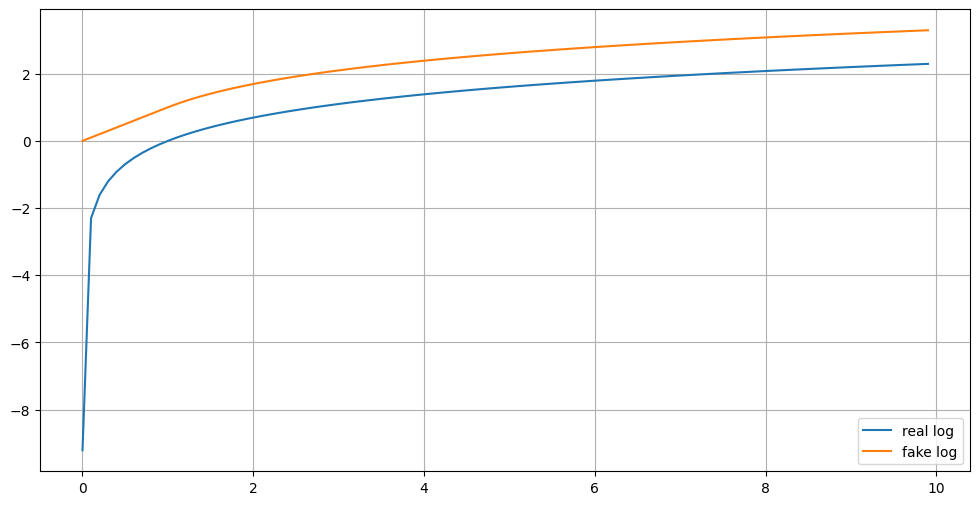

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
x = np.array([],dtype=np.float64)
y = np.array([],dtype=np.float64)
reallog = np.array([],dtype=np.float64)
for tij in np.arange(0.0001,10.0,0.1):
    x = np.append(x,tij)
    reallog = np.append(reallog,np.log(tij))
    #if (tij>=1.0):
    #    y.append(np.log(tij)+1.0)
    #else:
    #    y.append(tij)
y = fake_log(x)
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(x,reallog, label="real log")
ax.plot(x,y, label="fake log")
ax.grid(True)
legend = plt.legend(loc='lower right')
plt.show()

#Jeffreys Prior